In [11]:
# 신호등 탐지

# 1. 라이브러리 설치
!pip install ultralytics


In [12]:
# 2. 필수 import
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab import files
import requests


In [13]:


# 3. 빠른 실행 함수
def quick_traffic_light_detection():
    """원클릭 신호등 탐지"""

    print("신호등 이미지를 업로드해주세요:")
    uploaded = files.upload()

    if not uploaded:
        print("업로드가 취소되었습니다.")
        return

    image_path = list(uploaded.keys())[0]
    print(f"업로드 완료: {image_path}")

    # YOLO 모델 로드
    model = YOLO('yolov8n.pt')

    # 이미지 로드
    image = cv2.imread(image_path)

    # 신호등 탐지
    results = model(image_path)

    # 결과 분석
    traffic_lights = []
    for r in results:
        boxes = r.boxes
        if boxes is not None:
            for box in boxes:
                if int(box.cls) == 9:  # traffic light
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()
                    traffic_lights.append([int(x1), int(y1), int(x2), int(y2), float(confidence)])

    if not traffic_lights:
        print(" 신호등이 감지되지 않았습니다.")
        return

    print(f" {len(traffic_lights)}개의 신호등이 감지되었습니다!")

    # 색상 분석
    def get_traffic_light_color(roi):
        if roi.size == 0:
            return "unknown"

        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

        # 색상 범위 정의
        red_mask1 = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([10, 255, 255]))
        red_mask2 = cv2.inRange(hsv, np.array([170, 50, 50]), np.array([180, 255, 255]))
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, np.array([20, 50, 50]), np.array([30, 255, 255]))
        green_mask = cv2.inRange(hsv, np.array([40, 50, 50]), np.array([80, 255, 255]))

        # 밝기 필터
        bright_mask = cv2.inRange(hsv[:,:,2], 100, 255)

        # 최종 마스크
        red_final = cv2.bitwise_and(red_mask, bright_mask)
        yellow_final = cv2.bitwise_and(yellow_mask, bright_mask)
        green_final = cv2.bitwise_and(green_mask, bright_mask)

        # 점수 계산
        red_score = np.sum(red_final) / (roi.shape[0] * roi.shape[1] * 255)
        yellow_score = np.sum(yellow_final) / (roi.shape[0] * roi.shape[1] * 255)
        green_score = np.sum(green_final) / (roi.shape[0] * roi.shape[1] * 255)

        scores = {'red': red_score, 'yellow': yellow_score, 'green': green_score}
        best_color = max(scores, key=scores.get)

        if scores[best_color] < 0.01:
            return "unknown"

        return best_color

    # 결과 시각화
    annotated = image.copy()

    plt.figure(figsize=(15, 10))

    # 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # 분석 결과
    for i, (x1, y1, x2, y2, conf) in enumerate(traffic_lights):
        # ROI 추출
        roi = image[y1:y2, x1:x2]
        color = get_traffic_light_color(roi)

        # 색상별 박스 색깔
        colors = {
            'red': (0, 0, 255),
            'yellow': (0, 255, 255),
            'green': (0, 255, 0),
            'unknown': (128, 128, 128)
        }

        box_color = colors[color]

        # 박스 그리기
        cv2.rectangle(annotated, (x1, y1), (x2, y2), box_color, 3)

        # 텍스트
        text = f"{color.upper()}"
        cv2.rectangle(annotated, (x1, y1-30), (x1+100, y1), box_color, -1)
        cv2.putText(annotated, text, (x1+5, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        # 결과 출력
        status = {"red": " 정지", "yellow": " 주의", "green": " 진행", "unknown": " 불명확"}
        print(f"신호등 {i+1}: {color.upper()} - {status[color]} (신뢰도: {conf:.2f})")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title('Traffic Light Detection Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()



신호등 이미지를 업로드해주세요:


Saving 신호등3.jpg to 신호등3.jpg
업로드 완료: 신호등3.jpg

image 1/1 /content/신호등3.jpg: 416x640 1 car, 1 truck, 4 traffic lights, 160.3ms
Speed: 3.3ms preprocess, 160.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
 4개의 신호등이 감지되었습니다!
신호등 1: GREEN -  진행 (신뢰도: 0.50)
신호등 2: GREEN -  진행 (신뢰도: 0.37)
신호등 3: GREEN -  진행 (신뢰도: 0.35)
신호등 4: GREEN -  진행 (신뢰도: 0.31)


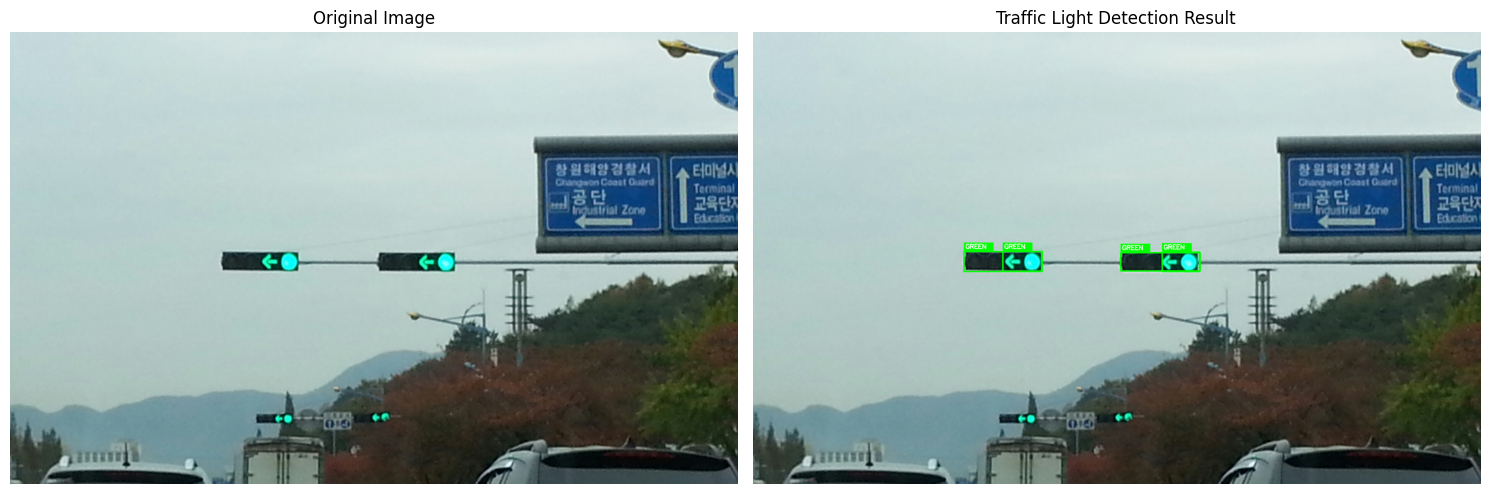

In [16]:
# 실행!
quick_traffic_light_detection()